# Bike Sharing Demand EDA & Baseline

<br>

# Bike Sharing Demand EDA

## 1. 데이터 둘러보기

주어진 데이터가 어떻게 구성되어 있는지 살펴보겠습니다. 우선 판다스로 훈련, 테스트, 제출 샘플 데이터를 DataFrame 형태로 불러오겠습니다.

In [1]:
import numpy as np
import pandas as pd # 판다스 임포트

# 데이터 경로
data_path = '/kaggle/input/bike-sharing-demand/'

train = pd.read_csv(data_path + 'train.csv') # 훈련 데이터
test = pd.read_csv(data_path + 'test.csv')   # 테스트 데이터
submission = pd.read_csv(data_path + 'sampleSubmission.csv') # 제출 샘플 데이터

`shape()` 함수로 훈련 데이터와 테스트 데이터의 크기를 확인해보겠습니다.

In [2]:
train.shape, test.shape

((10886, 12), (6493, 9))

훈련 데이터는 10,886행 12열로 구성되어 있고, 테스트 데이터는 6,493 행 9열로 구성되어 있습니다. 열의 개수는 피처 개수를 나타냅니다. 그런데 두 데이터의 피처 개수가 서로 다릅니다. 어떤 피처 데이터를 담고 있는지 직접 살펴보겠습니다. `head()` 함수는 DataFrame의 첫 5행을 출력합니다.

In [3]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


다음 표에 각 피처의 의미를 설명해놓았습니다.

| 피처명 | 설명 |
| ---- | --- |
| datetime | 기록 일시 (1시간 간격) |
| season | 계절 (1 : 봄, 2 : 여름, 3 : 가을, 4 : 겨울) |
| holiday | 공휴일 여부 (0 : 공휴일 아님, 1 : 공휴일) |
| workingday | 근무일 여부 (0 : 근무일 아님, 1 : 근무일) |
| weather | 날씨 (1: 맑음, 2 : 옅은 안개, 약간 흐림, 3 : 약간의 눈, 약간의 비와 천둥 번개, 흐림, 4: 폭우와 천둥 번개, 눈과 짙은 안개) |
| temp | 실제 온도 |
| atemp | 체감 온도 |
| humidity | 상대 습도 |
| windspeed | 풍속 |
| casual | 등록되지 않은 사용자(비회원) 수 |
| registered | 등록된 사용자(회원) 수 |
| count | 자전거 대여 수량 |

datetime부터 registered까지는 예측에 사용할 수 있는 피처고, count는 예측해야 할 타깃값 입니다. datetime은 한 시간 간격으로 기록되어 있습니다. 결국 예측해야 할 값은 시간당 총 자전거 대여 수량입니다. 테스트 데이터도 한번 보겠습니다.

In [4]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


테스트 데이터는 피처 수가 훈련 데이터보다 적습니다. 훈련 데이터의 피처에서 casual과 registered가 빠졌습니다.

훈련 데이터를 활용해 모델을 훈련한 뒤, 테스트 데이터를 활용해 대여 수량(count)을 예측해야 합니다. 예측할 때 사용하는 데이터가 테스트 데이터입니다. 그런데 테스트 데이터에 casual과 registered 피처가 없으므로 모델을 훈련할 때도 훈련 데이터의 분석 결과 casual과 registered 피처를 빼야 합니다.

이제 제출 샘플 파일이 어떻게 생겼는지 보겠습니다.

In [5]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


제출 파일은 보통 이런 형태입니다. 데이터를 구분하는 ID 값(여기서는 datetime)과 타깃값으로 구성되어 있습니다. 현재는 타깃값인 count가 모두 0입니다. 시간대별 대여 수량을 예측해 이 값을 바꾼 뒤 제출하면 됩니다. 여기서 ID 값(datetime)은 데이터를 구분하는 역할만 하므로 타깃값을 예측하는 데에는 아무런 도움을 주지 않습니다. 따라서 추후 모델 훈련 시 훈련 데이터에 있는 datetime 피처는 제거할 계획입니다.

`info()` 함수를 사용하면 DataFrame 각 열의 결측값이 몇 개인지, 데이터 타입은 무엇인지 파악할 수 있습니다.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


모든 피처의 비결측값 데이터 개수(Non-Null Count)가 전체 데이터 개수와 똑같은 10,886개이므로 훈련 데이터에는 결측값이 없습니다. 만약 결측값이 있다면 적절히 처리해줘야 합니다.

데이터 타입은 object, int64, float64로 다양하네요.

테스트 데이터도 살펴보겠습니다.

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


테스트 데이터에도 결측값이 없고, 데이터 타입도 훈련 데이터와 동일합니다.

이상으로 이번 경진대회에서 사용할 데이터의 모습을 간단히 둘러보았습니다.

<br>

## 2. 더 효과적인 분석을 위한 피처 엔지니어링

기본적인 분석을 마쳤다면 다음은 데이터 시각화 차례입니다. 데이터를 다양한 관점에서 시각화해보면 raw data 상태에서는 찾기 어려운 경향, 공통점, 차이 등이 드러날 수 있기 때문입니다. 그런데 일부 데이터는 시각화하기에 적합하지 않은 형태일 수 있습니다. 본 경진대회에서는 datetime 피처가 그렇습니다. 시각화하기 전에 이 피처를 분석하기 적합하게 변환(피처 엔지니어링)해봅시다.

datetime 피처의 데이터 타입은 object입니다. 판다스에서 object 타입은 문자열 타입이라고 보면 됩니다. datetime은 연도, 월, 일, 시간, 분, 초 로 구성되어 있습니다. 따라서 세부적으로 분석해보기 위해 구성요소별로 나누어보겠습니다. 파이썬 내장 함수인 분석 결과 `split()` 을 쓰면 쉽게 나눌 수 있습니다. datetime의 100번째 원소를 예로 들어 어떻게 나누는지 설명하겠습니다.

In [8]:
print(train['datetime'][100]) # datetime 100번째 원소
print(train['datetime'][100].split()) # 공백 기준으로 문자열 나누기
print(train['datetime'][100].split()[0]) # 날짜
print(train['datetime'][100].split()[1]) # 시간

2011-01-05 09:00:00
['2011-01-05', '09:00:00']
2011-01-05
09:00:00


datetime 피처는 object 타입이기 때문에 문자열처럼 다룰 수 있습니다. 앞의 예에서는 `split()` 함수를 사용해 공백 기준으로 앞 뒤 문자를 나누었습니다. 첫 번째 문자열 '2011-01-05'는 날짜 문자열이고, 두 번째 문자열 '09:00:00'은 시간 문자열입니다.

날짜 문자열을 다시 연도, 월, 일로 나눠보겠습니다.


In [9]:
print(train['datetime'][100].split()[0]) # 날짜
print(train['datetime'][100].split()[0].split('-')) # '-' 기준으로 문자열 나누기
print(train['datetime'][100].split()[0].split('-')[0]) # 연도
print(train['datetime'][100].split()[0].split('-')[1]) # 월
print(train['datetime'][100].split()[0].split('-')[2]) # 일

2011-01-05
['2011', '01', '05']
2011
01
05


"-" 문자를 기준으로 나누어 연도, 월, 일을 구했습니다.

이어서 시간 문자열을 시, 분, 초로 나누겠습니다. ":" 문자가 나누는 기준입니다.

In [10]:
print(train['datetime'][100].split()[1]) # 시간
print(train['datetime'][100].split()[1].split(':')) # ':' 기준으로 문자열 나누기
print(train['datetime'][100].split()[1].split(':')[0]) # 시간
print(train['datetime'][100].split()[1].split(':')[1]) # 분
print(train['datetime'][100].split()[1].split(':')[2]) # 초

09:00:00
['09', '00', '00']
09
00
00


다음으로 판다스 `apply()` 함수로 앞의 로직을 datetime에 적용해 날짜(date), 연도(year),월(month), 일(day), 시(hour), 분(minute), 초(second) 피처를 생성하겠습니다.

In [11]:
train['date'] = train['datetime'].apply(lambda x: x.split()[0]) # 날짜 피처 생성

# 연도, 월, 일, 시, 분, 초 피처를 차례로 생성
train['year'] = train['datetime'].apply(lambda x: x.split()[0].split('-')[0])
train['month'] = train['datetime'].apply(lambda x: x.split()[0].split('-')[1])
train['day'] = train['datetime'].apply(lambda x: x.split()[0].split('-')[2])
train['hour'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[0])
train['minute'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[1])
train['second'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[2])

`apply()` 함수는 DataFrame의 데이터를 일괄 가공해줍니다. 보다시피 종종 람다 lambda 함수와 함께 사용됩니다. 람다 함수를 DataFrame 축(기본값은 DataFrame의 각 열column에 대해 수행)을 따라 적용하는 기능을 합니다.

이제 요일 피처도 생성해보겠습니다. 요일 피처는 calendar와 datetime '라이브러리'를 활용해 만들 수 있습니다. 여기서 datetime은 날짜와 시간을 조작하는 라이브러리로 datetime 피처와는 다른 것입니다. 날짜 문자열에서 요일을 추출하는 방법을 한 단계씩 알아보겠습니다.

In [12]:
from datetime import datetime # datetime 라이브러리 임포트
import calendar

print(train['date'][100]) # 날짜
print(datetime.strptime(train['date'][100], '%Y-%m-%d')) # datetime 타입으로 변경
print(datetime.strptime(train['date'][100], '%Y-%m-%d').weekday()) # 문자열로 요일 변환
print(calendar.day_name[datetime.strptime(train['date'][100], '%Y-%m-%d').weekday()])

2011-01-05
2011-01-05 00:00:00
2
Wednesday


다소 복잡하지만 calendar와 datetime 라이브러리를 사용하면 요일 피처를 문자로 구할 수 있습니다. 0은 월요일, 1은 화요일, 2는 수요일순으로 매핑됩니다. 단, 모델을 훈련할 때는 피처 값을 문자로 바꾸면 안 됩니다. 머신러닝 모델은 숫자만 인식하기 때문입니다. 문자 피처도 모두 숫자로 변환해야 합니다. 여기서는 그래프로 나타냈을 때 쉽게 알아보려고 요일 피처를 문자열로 바꾼 겁니다.

앞의 로직을 `apply()` 함수로 적용해 요일(weekday) 피처를 추가하겠습니다.

In [13]:
train['weekday'] = train['date'].apply(
    lambda dateString:
    calendar.day_name[datetime.strptime(dateString, '%Y-%m-%d').weekday()]
)

다음은 season과 weather 피처 차례입니다. 이 두 피처는 범주형 데이터인데 현재 1, 2, 3, 4라는 숫자로 표현되어 있어서 정확히 어떤 의미인지 파악하기 어렵습니다. 시각화 시 의미가 잘 드러나도록 `map()` 함수를 사용하여 문자열로 바꾸겠습니다.

In [14]:
train['season'] = train['season'].map({1: 'Spring',
                                       2: 'Summer',
                                       3: 'Fall',
                                       4: 'Winter'})
train['weather'] = train['weather'].map({1: 'Clear',
                                         2: 'Mist, Few clouds',
                                         3: 'Light Snow, Rain, Thunderstorm',
                                         4: 'Heavy Rain, Thunderstorm, Snow, Fog'})

이제 훈련 데이터의 첫 5행을 출력해 피처가 어떻게 바뀌었는지 보겠습니다.

In [15]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00,Saturday
1,2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,00,00,Saturday
2,2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,01,01,02,00,00,Saturday
3,2011-01-01 03:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,01,01,03,00,00,Saturday
4,2011-01-01 04:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,01,01,04,00,00,Saturday


date, year, month, day, hour, minute, second, weekday 피처가 추가되었고, season과 weather 피처는 숫자에서 문자로 바뀌었습니다.

참고로 date 피처가 제공하는 정보는 모두 year, month, day 피처에도 있어서 추후 date 피처는 제거하겠습니다. 또한 세 달씩 '월'을 묶으면 '계절’이 됩니다. 즉, 세분화된 month 피처를 세 달씩 묶으면 season 피처와 의미가 같아집니다. 지나치게 세분화된 피처를 더 큰 분류로 묶으면 성능이 좋아지는 경우가 있어 여기서는 season 피처만 남기고 month 피처는 제거하겠습니다.

<br>

## 3. 데이터 시각화

피처를 추가한 훈련 데이터를 그래프로 시각화해보죠. 시각화는 탐색적 데이터 분석에서 가장 중요한 부분입니다. 데이터 분포나 데이터 간 관계를 한눈에 파악할 수 있기 때문입니다. 모델링에 도움될 만한 정보를 얻을 수도 있죠.

시각화를 위해 matplotlib과 seaborn 라이브러리를 활용하겠습니다. matplotlib은 파이썬으로 데이터를 시각화할 때 표준처럼 사용되는 라이브러리이며, seaborn은 matplotlib에 고수준 인터페이스를 덧씌운 라이브러리입니다.

먼저 두 라이브러리를 임포트합니다.

In [16]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

참고로 코드 `%matplotlib inline` 을 추가하면 matplotlib이 그린 그래프를 주피터 노트북에서 바로 출력해줍니다. 사실 캐글 환경에서는 %matplotlib inline이 없어도 그래프를 보여줍니다만, matplotlib을 사용하는 경우 관습적으로 쓰는 경향이 있어서 추가해뒀습니다.

이번 절은 주어진 데이터를 살펴보는 데 집중합니다. 이제부터 이 라이브러리들을 활용하여 각종 그래프를 그려보겠습니다.

### 분포도

분포도(distribution plot)는 수치형 데이터의 집계 값을 나타내는 그래프입니다. 집계 값은 총 개수나 비율 등을 의미합니다. 타깃값인 count의 분포도를 그려보겠습니다. 이번 장에서는 타깃값의 분포를 알면 훈련 시 타깃값을 그대로 사용할지 변환해 사용할지 파악할 수 있기 때문입니다.

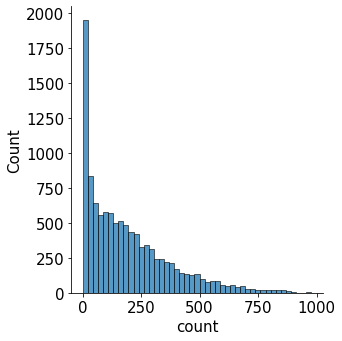

In [17]:
mpl.rc('font', size=15)     # 폰트 크기를 15로 설정
sns.displot(train['count']) # 분포도 출력

x축은 타깃값인 count를 나타내고, y축은 총 개수를 나타냅니다. 분포도를 보면 타깃값인 count가 0 근처에 몰려 있습니다. 즉, 분포가 왼쪽으로 많이 편향되어 있습니다. 회귀 모델이 좋은 성능을 내려면 데이터가 정규분포를 따라야 하는데,현재 타깃값 count는 정규분포를 따르지 않습니다. 따라서 현재 타깃값을 그대로 사용해 모델링한다면 좋은성능을 기대하기 어렵습니다.

데이터 분포를 정규분포에 가깝게 만들기 위해 가장 많이 사용하는 방법은 로그변환입니다. 로그변환은 count 분포와 같이 데이터가 왼쪽으로 편향되어 있을 때 사용합니다. 로그변환하는 방법은 간단합니다. 원하는 값에 로그를 취해주면 됩니다. count를 로그변환한 값의 분포를 살펴보겠습니다.

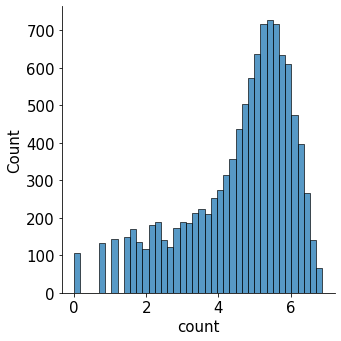

In [18]:
sns.displot(np.log(train['count']))

변환 전보다 정규분포에 가까워졌습니다. 타깃값 분포가 정규분포에 가까울수록 회귀 모델 성능이 좋다고 했습니다. 다시 말해, 피처를 바로 활용해 count를 예측하는 것보다 log(count)를 예측하는 편이 더 정확합니다. 따라서 우리도 타깃값을 log(count)로 변환해 사용하겠습니다.

다만, 마지막에 지수변환을 하여 실제 타깃값인 count로 복원해야합니다. `log(y)` 를 지수변환하면 가됩니다.

### 막대그래프

다음으로 연도, 월, 일, 시, 분, 초별로 총 여섯 가지의 평균 대여 수량을 막대 그래프로 그려보겠습니다. 이 피처들은 범주형 데이터입니다. 각 범주형 데이터에 따라 평균 대여 수량이 어떻게 다른지 파악하려고 합니다. 그래야 어떤 피처가 중요한지 알 수 있습니다. 이럴 때 막대 그래프를 이용합니다. 막대그래프는 seaborn의 `barplot()` 함수로 그릴 수 있습니다.

#### 스텝 1 : m행 n열 Figure 준비하기

첫 번째로 총 6개의 그래프(서브플롯)를 품는 3행 2열짜리 Figure를 준비합니다.

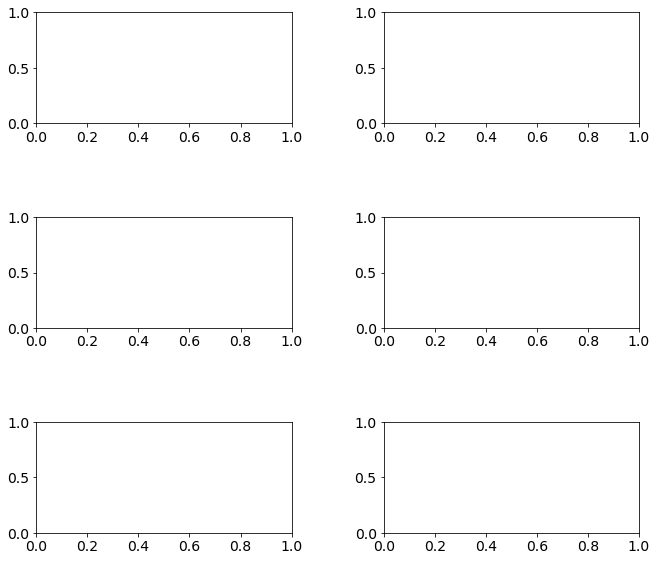

In [19]:
# 스텝 1 : m행 n열 Figure 준비
mpl.rc('font', size=14)       # 폰트 크기 설정
mpl.rc('axes', titlesize=15)  # 각 축의 제목 크기 설정
figure, axes = plt.subplots(nrows=3, ncols=2) # 3행 2열 Figure 생성
plt.tight_layout()            # 그래프 사이에 여백 확보
figure.set_size_inches(10, 9) # 전체 Figure 크기를 10x9 인치로 설정

`figure, axes = plt.subplots(nrows=3, ncols=2)` 은 matplotlib 라이브러리의 `subplots()` 함수 사용 예시입니다. 지금 예처럼 한 화면에 여러 그래프를 동시에 그릴 때 사용합니다. 파라미터를 두 개 받는데 nrows는 행 개수를, ncols는 열 개수를 뜻합니다. `plt.subplots(nrows=3, ncols=2)` 을 실행하면 3행 2열의 서브플롯subplot 전체가 figure 변수에 할당되며, 각각의 서브플롯 축 6개는 axes 변수에 할당됩니다.

이어서 axes에는 어떤 객체가 할당되어 있는지 출력해보겠습니다.

In [20]:
axes

array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

AxesSubplot 객체 6개가 3행 2열로 구성된 배열이 출력되었습니다. 출력 결과의 AxesSubplot 객체는 순서대로 서브플롯의 0행 0 열, 0행 1열, 1행 0열, 1행 1열, 2행 0열, 2행 1열 축을 의미합니다. 예를 들어, axes[0, 0]은 서브플롯의 0행 0열 축을 의미합니다.

`plt.tight_layout()` 은 서브플롯 사이에 여백을 줘 간격을 넓히는 기능을 합니다.

마지막으로 `figure.set_size_inches(10, 9)` 는 Figure 크기를 지정합니다. 서브플롯 하나의 크기가 아니라 서브플롯 6개를 합친 '전체' Figure 크기이며, 단위는 함수 이름에서 알 수 있듯이 인치 inch입니다. 첫 번째 파라미터로는 너비, 두 번째 파라미터로는 높이를 조정합니다. 여기서는 너비 10인치, 높이 9인치로 설정했습니다.

#### 스텝 2 : 각 축에 서브플롯 할당

이어서 연도, 월, 일, 시간, 분, 초별 평균 대여 수량 막대 그래프를 스텝 1에서 준비한 Figure의 각 축에 할당하겠습니다.

<AxesSubplot:xlabel='second', ylabel='count'>

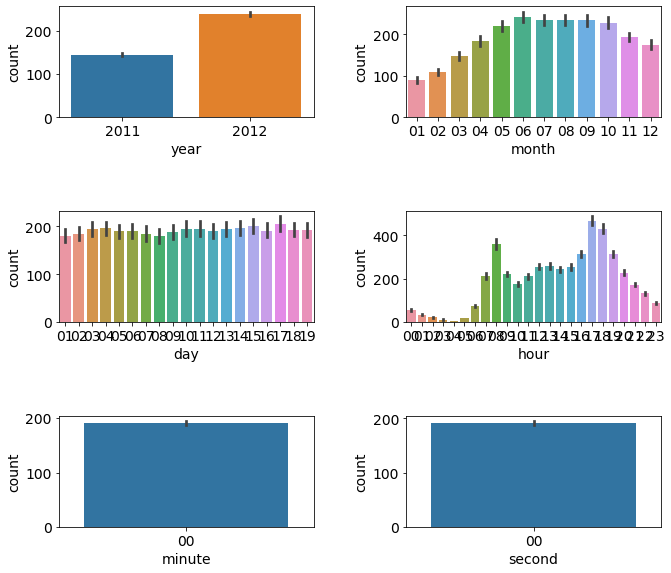

In [21]:
# 스텝 1 : m행 n열 Figure 준비
mpl.rc('font', size=14)       # 폰트 크기 설정
mpl.rc('axes', titlesize=15)  # 각 축의 제목 크기 설정
figure, axes = plt.subplots(nrows=3, ncols=2) # 3행 2열 Figure 생성
plt.tight_layout()            # 그래프 사이에 여백 확보
figure.set_size_inches(10, 9) # 전체 Figure 크기를 10x9 인치로 설정

# 스텝 2 : 각 축에 서브플롯 할당
# 각 축에 연도, 월, 일, 시간, 분, 초별 평균 대여 수량 막대 그래프 할당
sns.barplot(x='year', y='count', data=train, ax=axes[0, 0])
sns.barplot(x='month', y='count', data=train, ax=axes[0, 1])
sns.barplot(x='day', y='count', data=train, ax=axes[1, 0])
sns.barplot(x='hour', y='count', data=train, ax=axes[1, 1])
sns.barplot(x='minute', y='count', data=train, ax=axes[2, 0])
sns.barplot(x='second', y='count', data=train, ax=axes[2, 1])

막대 그래프 생성에는 seaborn의 `barplot()` 함수를 이용했습니다. x 파라미터에 연도, 월, 일, 시간, 분, 초를 전달하고, y 파라미터에 대여 수량을 전달했습니다. data 파라미터에는 훈련 데이터를 DataFrame 형식으로 전달하면 됩니다. ax 파라미터에는 AxesSubplot 객체를 전달하면 됩니다. 0행 0열의 축부터 2행 1열의 축까지 순서대로 전달했습니다.

하지만 각 서브플롯이 어떤 정보를 표현하는지가 한눈에 안 들어오고, 어떤 서브플롯은 x축 라벨이 서로 겹치는 등 아쉬운 점이 조금 보입니다.

#### 스텝 3 : (선택) 세부 설정

아쉬움이 남는다면 다양한 형태로 세부 속성을 설정할 수 있습니다. 이번 예에서는 각 서브플롯에 제목을 추가하고, x축 라벨이 겹치지 않게 개선해보겠습니다. 먼저 각 축에 그려진 서브플롯에 제목을 달아줍니다.

이어서 1행의 두 서브플롯의 x축 라벨들을 90도 회전시키겠습니다.

보다시피 axis 파라미터에 원하는 축을 명시하고 labelrotation 파라미터에 회전 각도를 입력하면 됩니다. axis의 값으로는 'x', 'y', 'both'를 지정할 수 있으며, 기본값이 'both'이므로 생략하면 두 축을 한꺼번에 회전시킵니다.

이상으로 세부 설정까지 모두 마쳤습니다. 다음의 전체 코드를 실행하면 이번 절에서 처음 보여드린 막대 그래프가 나타납니다.

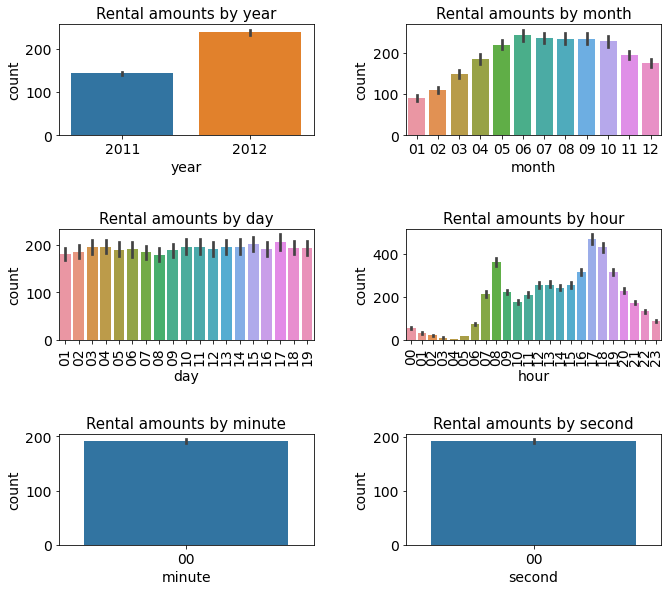

In [22]:
# 스텝 1 : m행 n열 Figure 준비
mpl.rc('font', size=14)       # 폰트 크기 설정
mpl.rc('axes', titlesize=15)  # 각 축의 제목 크기 설정
figure, axes = plt.subplots(nrows=3, ncols=2) # 3행 2열 Figure 생성
plt.tight_layout()            # 그래프 사이에 여백 확보
figure.set_size_inches(10, 9) # 전체 Figure 크기를 10x9 인치로 설정

# 스텝 2 : 각 축에 서브플롯 할당
# 각 축에 연도, 월, 일, 시간, 분, 초별 평균 대여 수량 막대 그래프 할당
sns.barplot(x='year', y='count', data=train, ax=axes[0, 0])
sns.barplot(x='month', y='count', data=train, ax=axes[0, 1])
sns.barplot(x='day', y='count', data=train, ax=axes[1, 0])
sns.barplot(x='hour', y='count', data=train, ax=axes[1, 1])
sns.barplot(x='minute', y='count', data=train, ax=axes[2, 0])
sns.barplot(x='second', y='count', data=train, ax=axes[2, 1])

# 스텝 3 : 세부 설정
# 3-1 : 서브플롯에 제목 달기
axes[0, 0].set(title='Rental amounts by year')
axes[0, 1].set(title='Rental amounts by month')
axes[1, 0].set(title='Rental amounts by day')
axes[1, 1].set(title='Rental amounts by hour')
axes[2, 0].set(title='Rental amounts by minute')
axes[2, 1].set(title='Rental amounts by second')

# 3-2 : 1행에 위치한 서브플롯들의 x축 라벨 90도 회전
axes[1, 0].tick_params(axis='x', labelrotation=90)
axes[1, 1].tick_params(axis='x', labelrotation=90)

보다시피 총 6개의 그래프를 3행 2열로 배치해 그렸습니다. 어떤 정보를 담고 있는지 가볍게 훑어봅시다.
1. '연도별 평균 대여 수량' 그래프
    * 2011년보다 2012년에 대여가 많았습니다.
2. '월별 평균 대여 수량' 그래프
    * 추세를 파악할 수 있습니다.
    * 평균 대여 수량은 6월에 가장 많고 1월에 가장 적습니다. 날씨가 따뜻할수록 대여 수량이 많다고 짐작할 수 있습니다.
3. '일별 평균 대여 수량' 그래프
    * 일별 대여 수량에는 뚜렷한 차이가 없습니다.
    * 훈련 데이터에는 매월 1일부터 19일까지의 데이터만 있습니다. 나머지 20일부터 월말까지의 데이터는 테스트 데이터에 있습니다. 그래서 일자(day)는 피처로 사용하지 못합니다.
    * day를 피처로 사용하려면 훈련 데이터와 테스트 데이터에 공통된 값이 있어야 하는데, 훈련 데이터의 day와 테스트 데이터의 day는 전혀 다른 값을 갖기 때문입니다.
4. '시간별 평균 대여 수량' 그래프
    * 그래프 모양이 쌍봉형입니다.
    * 새벽 4시에 대여 수량이 가장 적습니다. 당연하겠죠. 새벽 4시에 자전거를 타는 사람은 거의 없을 테니까요.
    * 반면 아침 8시와 저녁 5~6시에 대여가 가장 많습니다. 사람들이 등하교 혹은 출퇴근 길에 자전거를 많이 이용한다고 짐작해볼 수 있습니다.
5. '분별, 초별 평균 대여 수량 그래프'
    * 아무 정보도 담고 있지 않습니다.
    * 훈련 데이터에 분과 초는 모두 0으로 기록되어 있기 때문입니다.
    * 따라서 나중에 모델을 훈련할 때 분과 초 피처는 사용하지 않겠습니다.

### 박스플롯

박스플롯(box plot) 은 범주형 데이터에 따른 수치형 데이터 정보를 나타내는 그래프입니다. 막대 그래프보다 더 많은 정보를 제공하는 특징이 있습니다.

여기서는 계절, 날씨, 공휴일, 근무일(범주형 데이터)별 대여 수량(수치형 데이터)을 박스플롯으로 그려보겠습니다. 각 범주형 데이터에 따라 타깃값인 대여 수량이 어떻게 변하는지 알 수 있습니다.

이번에는 2행 2열 Figure를 만들 것이며, 코드는 막대 그래프 때와 같은 'Figure 준비' '서브플롯 할당' → '세부 설정' 순서로 작성했습니다.

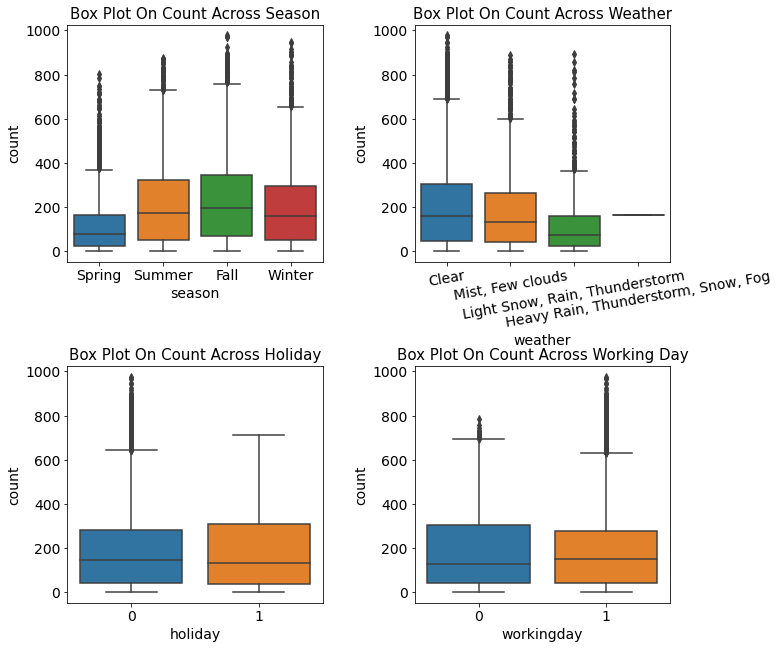

In [23]:
# 스텝 1 : m행 n열 Figure 준비
figure, axes = plt.subplots(nrows=2, ncols=2) # 2행 2열
plt.tight_layout()
figure.set_size_inches(10, 10)

# 스텝 2 : 서브플롯 할당
# 계절, 날씨, 공휴일, 근무일별 대여 수량 박스플롯
sns.boxplot(x='season', y='count', data=train, ax=axes[0, 0])
sns.boxplot(x='weather', y='count', data=train, ax=axes[0, 1])
sns.boxplot(x='holiday', y='count', data=train, ax=axes[1, 0])
sns.boxplot(x='workingday', y='count', data=train, ax=axes[1, 1])

# 스텝 3 : 세부 설정
# 3-1 : 서브플롯에 제목 달기
axes[0, 0].set(title='Box Plot On Count Across Season')
axes[0, 1].set(title='Box Plot On Count Across Weather')
axes[1, 0].set(title='Box Plot On Count Across Holiday')
axes[1, 1].set(title='Box Plot On Count Across Working Day')

# 3-2 : x축 라벨 겹침 해결
axes[0, 1].tick_params(axis='x', labelrotation=10) # 10도 회전

1. 계절별 대여 수량 박스플롯
    * 자전거 대여 수량은 봄에 가장 적고, 가을에 가장 많습니다.
2. 날씨별 대여 수량 박스플롯
    * 날씨가 좋을 때 대여 수량이 가장 많고, 안 좋을수록 수량이 적습니다.
    * 폭우, 폭설이 내리는 날씨(그래프의 가장 오른쪽 박스)에는 대여 수량이 거의 없습니다.
3. 공휴일 여부에 따른 대여 수량 박스플롯
    * x축 라벨 0은 공휴일이 아니라는 뜻이고, 1은 공휴일이라는 뜻입니다. 공휴일일 때와 아닐 때 자전거 대여 수량의 중앙값은 거의 비슷합니다.
    * 다만, 공휴일이 아닐 때는 이상치(oulier)가 많습니다.
4. 근무일 여부에 따른 대여 수량 박스플롯
    * 근무일일 때 이상치가 많습니다.
    * 참고로 근무일은 공휴일과 주말을 뺀 나머지 날을 뜻합니다.

### 포인트플롯

다음으로 근무일, 공휴일, 요일, 계절, 날씨에 따른 시간대별 평균 대여 수량을 포인트플롯(point plot) 으로 그려보겠습니다. 포인트플롯은 범주형 데이터에 따른 수치형 데이터의 평균과 신뢰구간을 점과 선으로 표시합니다. 막대 그래프와 동일한 정보를 제공하지만, 한 화면에 여러 그래프를 그려 서로 비교해보기에 더 적합합니다.

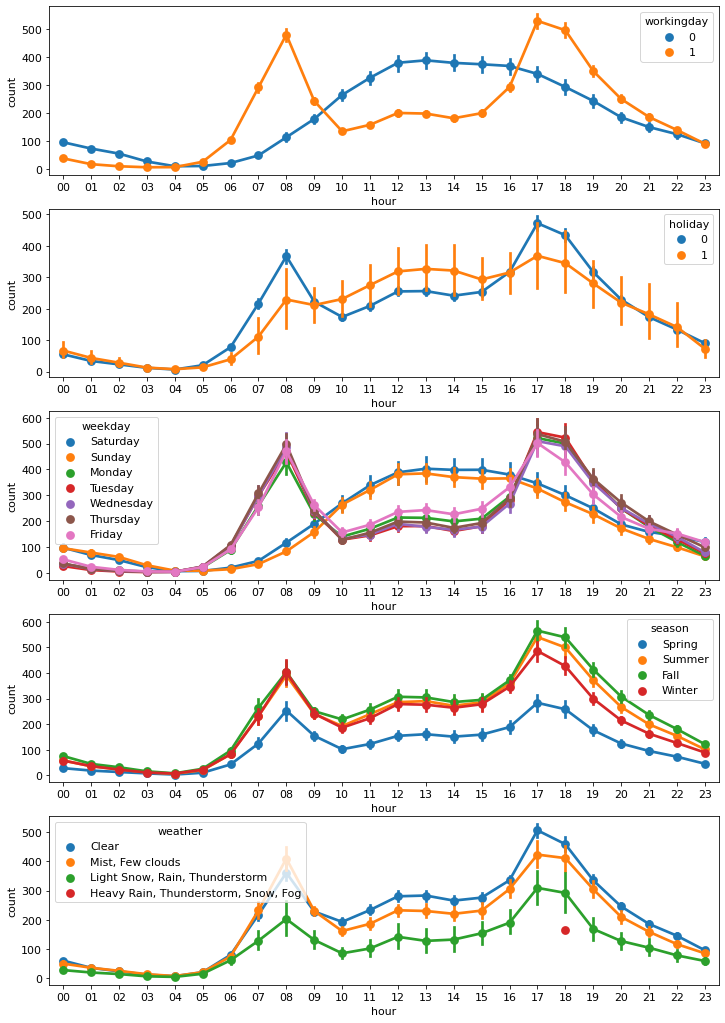

In [24]:
# 스텝 1 : m행 n열 Figure 준비
mpl.rc('font', size=11)
figure, axes = plt.subplots(nrows=5) # 5행 1열
figure.set_size_inches(12, 18)

# 스텝 2 : 서브플롯 할당
# 근무일, 공휴일, 요일, 계절, 날씨에 따른 시간대별 평균 대여 수량 포인트플롯
sns.pointplot(x='hour', y='count', data=train, hue='workingday', ax=axes[0])
sns.pointplot(x='hour', y='count', data=train, hue='holiday', ax=axes[1])
sns.pointplot(x='hour', y='count', data=train, hue='weekday', ax=axes[2])
sns.pointplot(x='hour', y='count', data=train, hue='season', ax=axes[3])
sns.pointplot(x='hour', y='count', data=train, hue='weather', ax=axes[4]);

모든 포인트플롯의 hue 파라미터에 비교하고 싶은 피처를 전달했습니다. hue 파라미터에 전달한 피처를 기준으로 그래프가 나뉩니다.

1. 근무일 여부에 따른 포인트플롯
    * 근무일에는 출퇴근 시간에 대여 수량이 많고, 쉬는 날에는 오후 12~2시에 가장 많습니다.
2. 공휴일 여부에 따른 포인트플롯
    * 근무일 여부에 따른 포인트플롯과 비슷한 양상
3. 요일에 따른 포인트플롯
    * 근무일 여부에 따른 포인트플롯과 비슷한 양상
4. 계절에 따른 시간대별 포인트플롯
    * 대여 수량은 가을에 가장 많고, 봄에 가장 적습니다.
5. 날씨에 따른 시간대별 포인트플롯
    * 예상대로 날씨가 좋을 때 대여량이 가장 많습니다.
    * 그런데 폭우, 폭설이 내릴 때 18시(저녁 6시)에 대여 건수가 있습니다. 정말 급한 일이 있었나 봅니다. 이런 이상치는 제거를 고려해보는것도 괜찮은 방법입니다.
    * 추후 이 데이터는 제거하겠습니다.

### 회귀선을 포함한 산점도 그래프

수치형 데이터인 온도, 체감 온도, 풍속, 습도별 대여 수량을 회귀선을 포함한 산점도 그래프(scatter plot graph with regression line) 로 그려보겠습니다. 회귀선을 포함한 산점도 그래프는 수치형 데이터 간 상관관계를 파악하는 데 사용합니다.

이 그래프는 seaborn의 `regplot()` 함수로 그릴 수 있습니다.

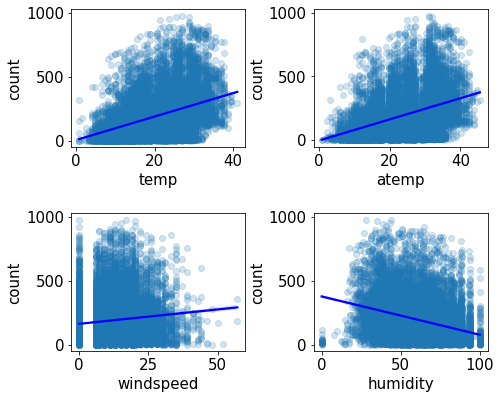

In [25]:
# 스텝 1 : m행 n열 Figure 준비
mpl.rc('font', size=15)
figure, axes = plt.subplots(nrows=2, ncols=2) # 2행 2열
plt.tight_layout()
figure.set_size_inches(7, 6)

# 스텝 2 : 서브플롯 할당
# 온도, 체감 온도, 풍속, 습도 별 대여 수량 산점도 그래프
sns.regplot(x='temp', y='count', data=train, ax=axes[0, 0], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='atemp', y='count', data=train, ax=axes[0, 1], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='windspeed', y='count', data=train, ax=axes[1, 0], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='humidity', y='count', data=train, ax=axes[1, 1], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'});

`regplot()` 함수의 파라미터 중 `scatter_kws={'alpha': 0.2}` 는 산점도 그래프에 찍히는 점의 투명도를 조절합니다. alpha를 0.2로 설정하면 평소에 비해 20% 수준으로 투명해집니다. alpha가 1이면 완전 불투명하고, 0이면 완전 투명해서 안 보입니다.

이어서 `line_kws={'color': 'blue'}` 는 회귀선의 색상을 선택하는 파라미터입니다. 회귀선이 잘 보이도록 그래프에 찍히는 점보다 짙은 색으로 설정했습니다.

회귀선 기울기로 대략적인 추세를 파악할 수 있습니다.
1. 온도 및 체감온도 그래프
    * 온도와 체감 온도가 높을수록 대여 수량이 많습니다.
2. 습도 그래프
    * 습도는 낮을수록 대여를 많이 합니다.
    * 다시 말해 대여 수량은 추울 때보다 따뜻할 때 많고, 습할 때보다 습하지 않을 때 많습니다.
3. 풍속 그래프
    * 회귀선을 보면 풍속이 셀수록 대여 수량이 많습니다. 바람이 약할수록 많을 것 같은데 조금 이상하군요.
    * 이유는 windspeed 피처에 결측값이 많기 때문입니다. 자세히 보면 풍속이 0인 데이터가 꽤 많습니다. 실제 풍속이 0이 아니라 관측치가 없거나 오류로 인해 0으로 기록됐을 가능성이 높습니다.
    * 결측값이 많아서 그래프만으로 풍속과 대여 수량의 상관관계를 파악하기는 힘듭니다. 결측값이 많은 데이터는 적절히 처리해야 합니다.
    * 결측값을 다른 값으로 대체하거나 windspeed 피처 자체를 삭제하면 됩니다. 우리는 피처 자체를 삭제할 것입니다.

### 히트맵

temp, atemp, humidity, windspeed, count는 수치형 데이터입니다. 수치형 데이터끼리 어떤 상관관계가 있는지 알아보겠습니다. `corr()` 함수는 DataFrame 내의 피처 간 상관계수를 계산해 반환합니다.

In [26]:
train[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()

,temp,atemp,humidity,windspeed,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,0.394454,0.389784,-0.317371,0.101369,1.000000


하지만 조합이 많아 어느 피처들의 관계가 깊은지 한눈에 들어오지 않습니다. 히트맵(heatmap)이 필요한 순간입니다. 히트맵은 데이터 간 관계를 색상으로 표현하여, 여러 데이터를 한눈에 비교하기에 좋습니다. 히트맵은 seaborn의 `heatmap()` 함수로 그릴 수 있습니다.

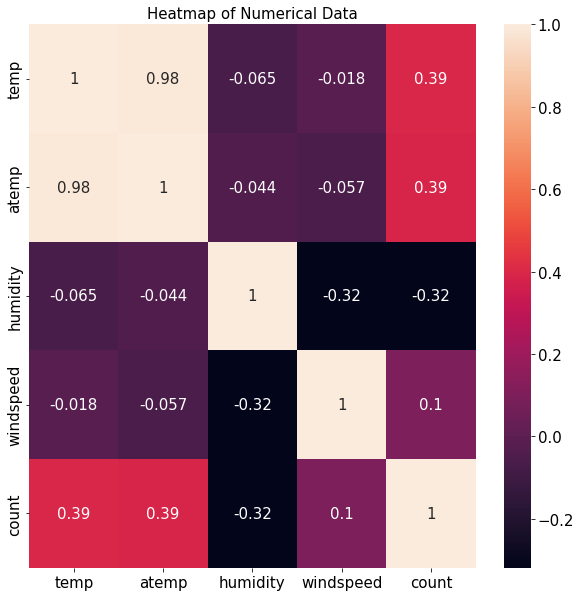

In [27]:
# 피처 간 상관관계 매트릭스
corrMat = train[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr() 
fig, ax = plt.subplots() 
fig.set_size_inches(10, 10)
sns.heatmap(corrMat, annot=True) # 상관관계 히트맵 그리기
ax.set(title='Heatmap of Numerical Data');

`corr()` 함수로 구한 상관관계 매트릭스 corrMat를 `heatmap()` 함수에 인수로 넣어주면 됩니다. 이때 annot 파라미터를 True로 설정하면 상관계수가 숫자로 표시됩니다.

온도(temp)와 대여 수량(count) 간 상관계수는 0.39 입니다. 양의 상관관계를 보이는군요. 온도가 높을수록 대여 수량이 많다는 뜻입니다. 반면, 습도(humidity)와 대여 수량은 음수이니 습도가 낮을수록 대여 수량이 많다는 뜻입니다. 앞서 산점도 그래프에서 분석한 내용과 동일합니다.

풍속(windspeed)과 대여 수량의 상관계수는 0.1입니다. 상관관계가 매우 약합니다. windspeed 피처는 대여 수량 예측에 별 도움을 주지 못할 것 같습니다. 성능을 높이기 위해 모델링 시 windspeed 피처는 제거하겠습니다(참고로 바로 앞의 '회귀선을 포함한 산점도 그래프' 절에서는 결측값이 많다는 이유로 같은 결론에 도달했습니다).

<br>

## 4. 분석 정리 및 모델링 전략

### 분석 정리

지금까지 다양한 측면에서 데이터를 살펴보았습니다. 분석 과정에서 파악한 주요 내용을 정리해보겠습니다.

1. 타깃값 변환 : 분포도 확인 결과 타깃값인 count가 0 근처로 치우쳐 있으므로 로그변환하여 정규분포에 가깝게 만들어야 합니다. 타깃값을 count가 아닌 log(count)로 변환해 사용할 것이므로 마지막에 다시 지수변환해 count로 복원해야 합니다.

2. 파생 피처 추가 : datetime 피처는 여러 가지 정보의 혼합체이므로 각각을 분리해 year, month, day, hour, minute, second 피처를 생성할 수 있습니다.

3. 파생 피처 추가 : datetime에 숨어 있는 또 다른 정보인 요일(weekday) 피처를 추가하겠습니다.

4. 피처 제거 : 테스트 데이터에 없는 피처는 훈련에 사용해도 큰 의미가 없습니다. 따라서 훈련 데이터에만 있는 casual과 registered 피처는 제거하겠습니다.

5. 피처 제거 : datetime 피처는 인덱스 역할만 하므로 타깃값 예측에 아무런 도움이 되지 않습니다.

6. 피처 제거 : date 피처가 제공하는 정보는 year, month, day 피처에 담겨 있습니다.

7. 피처 제거 : month는 season 피처의 세부 분류로 볼 수 있습니다. 데이터가 지나치게 세분화되어 있으면 분류별 데이터 수가 적어서 오히려 학습에 방해가 되기도 합니다.

8. 피처 제거 : 막대 그래프 확인 결과 파생 피처인 day는 분별력이 없습니다.

9. 피처 제거 : 막대 그래프 확인 결과 파생 피처인 minute와 second에는 아무런 정보가 담겨있지 않습니다.

10. 이상치 제거 : 포인트 플롯 확인 결과 weather가 4인 데이터는 이상치입니다.

11. 피처 제거 : 산점도 그래프와 히트맵 확인 결과 windspeed 피처에는 결측값이 많고 대여 수량과의 상관관계가 매우 약합니다.

### 모델링 전략

경진대회에서 우수한 성적을 거두려면 본인만의 최적화된 모델을 구상해야 합니다. 하지만 캐글과 친해지기 위한 몸풀기 목적이 강하므로 사이킷런이 제공하는 기본 모델들만 사용하기로 했습니다. 차후 자신이 만든 모델이 최소한 기본 모델들보다는 우수해야 대회에 참여한 의의가 있을 테니 이번 기회에 친해지길 바랍니다.
* 베이스라인 모델 : 가장 기본적인 회귀 모델인 LinearRegression 채택
* 성능 개선 : 릿지, 라쏘, 랜덤 포레스트 회귀 모델
    * 피처 엔지니어링 : 앞의 분석 수준에서 모든 모델에서 동일하게 수행
    * 하이퍼파라미터 최적화 : 그리드서치
* 기타 : 타깃값이 count가 아닌 log(count)임

<br>

# Bike Sharing Demand Baseline

## 1. Baseline Start

이번 절에서는 앞 절에서 추린 피처들을 활용해 베이스라인 모델을 훈련하고 결과를 제출해보겠습니다.

베이스라인 모델이란 뼈대가 되는 가장 기본적인 모델을 의미합니다. 우리는 베이스라인 모델에서 출발해 성능을 점차 향상시키는 방향으로 모델링할 것입니다. 경진대회에 참가하다 보면 다른참가자들이 베이스라인 모델을 공유할 겁니다. 공유된 모델을 사용해도 되고, 직접 자신만의 모델을 만들어도 됩니다.

이번 장에서는 사이킷런이 제공하는 기본 선형 회귀 모델을 베이스라인으로 사용할 것입니다. 전체 프로세스는 다음과 같습니다.

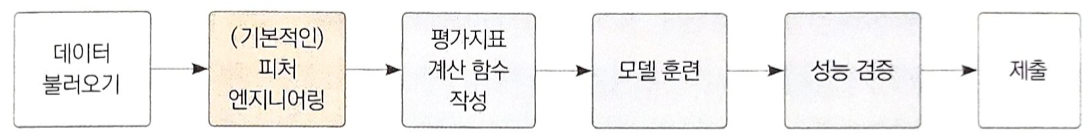

In [28]:
import pandas as pd

# 데이터 경로
data_path = '/kaggle/input/bike-sharing-demand/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

<br>

## 2. 피처 엔지니어링

피처 엔지니어링은 데이터를 변환하는 작업입니다. 보통은 이 변환을 훈련 데이터와 테스트 데이터에 공통으로 반영해야 하기 때문에, 피처 엔지니어링 전에 두 데이터를 합쳤다가 다 끝나면 도로 나눠줍니다.

그런데 데이터를 합치기 전에 훈련 데이터에서 이상치 하나만 제거하고 가겠습니다.

### 이상치 제거

앞서 포인트 플롯에서 확인한 결과 훈련 데이터에서 weather가 4인 데이터(폭우, 폭설이 내리는 날 저녁 6시에 대여)는 이상치였습니다. 제거하겠습니다.

In [29]:
# 훈련 데이터에서 weather가 4가 아닌 데이터만 추출
train = train[train['weather'] != 4]

### 데이터 합치기

훈련 데이터와 테스트 데이터에 같은 피처 엔지니어링을 적용하기 위해 두 데이터를 하나로 합치겠습니다. 판다스의 `concat()` 함수를 사용하면 축을 따라 DataFrame을 이어붙일 수 있습니다.

훈련 데이터는 10,886행, 테스트 데이터는 6,493행으로 구성되어 있습니다. 합치면 17,379행입니다. 앞서 weather가 4인 데이터를 제거했으니(1개 있음), 최종적으로 17,378행이 됩니다. 다음 코드를 실행해 제대로 합쳐지는지 보겠습니다.



In [30]:
all_data_temp = pd.concat([train, test])
all_data_temp

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


총 17,378행인데 인덱스가 6,492까지밖에 안 보입니다. 그림에서는 중간이 생략되어 있는데, 실제로는 0부터 10,885 까지 매기고 다시 0부터 6,492까지 매긴 결과입니다(중간에 앞서 제거한 인덱스도 있습니다). 원래 데이터의 인덱스를 무시하고 이어붙이려면 `ignore_index=True` 를 전달하면 됩니다.

In [31]:
all_data = pd.concat([train, test], ignore_index=True)
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


인덱스가 0부터 17,377까지 잘 나타났습니다. 테스트 데이터에 casual, registered 피처와 count 타깃값이 없으므로 NaN(Not a Number) 으로 표시된 것도 볼 수 있습니다.

### 파생 피처(변수) 추가

위에서 다룬 피처 엔지니어링(파생 피처 추가)을 비슷한 방식으로 적용해보겠습니다.

In [32]:
from datetime import datetime

# 날짜 피처 생성
all_data['date'] = all_data['datetime'].apply(lambda x: x.split()[0])

# 연도 피처 생성
all_data['year'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[0])

# 월 피처 생성
all_data['month'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[1])

# 시 피처 생성
all_data['hour'] = all_data['datetime'].apply(lambda x: x.split()[1].split(':')[0])

# 요일 피처 생성
all_data['weekday'] = all_data['date'].apply(lambda dateString: datetime.strptime(dateString, '%Y-%m-%d').weekday())

훈련 데이터는 매달 1일부터 19일까지의 기록이고, 테스트 데이터는 매달 20일부터 월말까지의 기록입니다. 그러므로 대여 수량을 예측할 때 일(day) 피처는 사용할 필요가 없습니다. minute와 second 피처도 모든 기록에서 값이 같으므로 예측에 사용할 필요가 없습니다. 그래서 day, minute, second는 피처로 생성하지 않았습니다.

### 필요 없는 피처 제거

이제 훈련 데이터와 테스트 데이터에서 필요 없는 피처를 제거하겠습니다. casual과 registered 피처는 테스트 데이터에 없는 피처이므로 제거하겠습니다. datetime 피처는 인덱스 역할이고, date 피처가 갖는 정보는 다른 피처들(year, month, day)에도 담겨 있기 때문에 datetime과 date 피처도 필요 없습니다. season 피처가 month의 대분류 성격이라서 month 피처도 제거하겠습니다. windspeed 피처도 타깃값과 상관관계가 약해서 제거하겠습니다.

In [33]:
drop_features = ['casual', 'registered', 'datetime', 'date', 'windspeed', 'month']

all_data = all_data.drop(drop_features, axis=1)

casual, registered, datetime, date, windspeed, month 피처를 제거했습니다. 필요 없는 피처를 제거함으로써 모델링할 때 사용할 피처를 모두 선별했습니다. 탐색적 데이터 분석에서 얻은 인사이트를 활용해 의미 있는 피처와 불필요한 피처를 구분한 것입니다. 이러한 과정을 피처 선택이라고 합니다.

### 피처 선택이란?

모델링 시 데이터의 특징을 잘 나타내는 주요 피처만 선택하는 작업을 피처 선택(feature selection) 이라고 합니다. 피처 선택은 머신러닝 모델 성능에 큰 영향을 줍니다. 타깃값 예측과 관련 없는 피처가 많다면 오히려 예측 성능이 떨어집니다. 피처가 많다고 무조건 좋은 게 아니라는 말입니다. 예측 성능을 높이려면 타깃값과 관련 있는 피처가 필요합니다.

피처 선택 방법에 정답은 없습니다. 어떤 피처를 선택해야 성능이 가장 좋을지 바로 알 방법은 없습니다. 탐색적 데이터 분석, 피처 중요도(feature importance), 상관관계 매트릭스 등을 활용해 종합적으로 판단해야 합니다.

이상으로 모든 피처 엔지니어링을 끝냈습니다.

### 데이터 나누기

모든 피처 엔지니어링을 적용했으므로 훈련 데이터와 테스트 데이터를 다시 나누겠습니다.

In [34]:
# 훈련 데이터와 테스트 데이터 나누기
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

# 타깃값 count 제거
X_train = X_train.drop(['count'], axis=1)
X_test = X_test.drop(['count'], axis=1)

y = train['count'] # 타깃값

타깃값이 있으면 훈련 데이터이고, 없으면 테스트 데이터입니다. `all_data['count']`가 타깃값입니다. 따라서 `all_data['count']` 가 null이 아니면 훈련 데이터입니다. 그래서 훈련 데이터를 추릴 때는 `pd.isnull()` 앞에 부정(not)을 의미하는 '~' 기호를 붙였습니다.

이렇게 나눈 X_train과 X_test에는 타깃값인 count도 포함돼 있어 제거했습니다. 그리고 타깃값인 `train['count']` 는 변수 y에 따로 할당했습니다.

피처 엔지니어링을 모두 마친 후 훈련 데이터 구성이 어떻게 바뀌었는지 살펴보겠습니다.

In [35]:
X_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,2011,00,5
1,1,0,0,1,9.02,13.635,80,2011,01,5
2,1,0,0,1,9.02,13.635,80,2011,02,5
3,1,0,0,1,9.84,14.395,75,2011,03,5
4,1,0,0,1,9.84,14.395,75,2011,04,5


처음 훈련 데이터와 비교해보면 datetime, windspeed, casual, registered, count가 빠졌고, 대신 year, hour, weekday가 추가되었습니다.

<br>

## 3. 평가지표 계산 함수 작성

훈련이란 어떠한 능력을 개선하기 위해 배우거나 단련하는 행위입니다. 따라서 훈련이 제대로 이루어졌는지 확인하려면 대상 능력을 평가할 수단, 즉 평가지표가 필요합니다. 그래서 본격적인 훈련에 앞서 본 경진대회 평가지표인 RMSLE를 계산하는 함수를 만들겠습니다.

In [36]:
import numpy as np

def rmsle(y_true, y_pred, convertExp=True):
    # 지수변환
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
    
    # 로그변환 후 결측값을 0으로 변환
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))
    
    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))

    return output

실제 타깃값 y_true와 예측값 y_pred를 인수로 전달하면 RMSLE 수치를 반환하는 함수입니다.

convertExp는 입력 데이터를 지수변환할지를 정하는 파라미터입니다. 기본값인 convertExp=True를 전달하면 y_true와 y_pred를 지수변환합니다. 지수변환에는 넘파이 내장 함수인 `exp()` 를 이용했습니다. 지수변환하는 이유는 타깃값으로 count가 아닌 log(count)를 사용하기 때문입니다. 예측한 log(count)에 지수변환을 하면 count를 구할수 있습니다. 만약 타깃값이 정규분포를 따른다면 타깃값으로 count를 그대로 사용해도 됩니다. 그럴 경우 RMSLE를 계산할 때 지수변환을 하지 않아도 됩니다.

또한 y_true와 y_pred를 로그변환하고 결측값은 0으로 변환합니다. 참고로 `np.log()` 함수의 밑은 e입니다. `np.nan_to_num()` 함수는 NaN 결측값을 모두 0으로 바꾸는 기능을 합니다. 또한 `np.log(y+1)` 은 간단히 `np.log1p(y)` 로 표현하기도 합니다.

<br>

## 4. 모델 훈련

데이터와 평가 함수가 준비되었으니 본격적으로 모델을 생성한 뒤 훈련시켜보겠습니다.

먼저 사이킷런이 제공하는 가장 간단한 선형 회귀 모델인 LinearRegression을 임포트하여 모델을 생성합니다.

In [37]:
from sklearn.linear_model import LinearRegression

linear_reg_model = LinearRegression()

이어서 훈련 데이터로 모델을 훈련시킵니다.

In [38]:
log_y = np.log(y) # 타깃값 로그변환
linear_reg_model.fit(X_train, log_y) # 모델 훈련

LinearRegression()

훈련 전에 타깃값을 로그변환했습니다. y는 타깃값인 train['count']를 할당한 변수였죠.

선형 회귀 모델을 훈련한다는 것은 독립변수(피처)인 X_train과 종속변수(타깃값)인 log_y에 대응하는 최적의 선형 회귀 계수를 구한다는 의미입니다. 선형 회귀 식은 다음과 같습니다.

$$Y = \theta_0 + \theta_1x_1 + \theta_2x_2 + \theta_3x_3$$

이 선형 회귀 식으로 다시 설명해보겠습니다.

독립변수 $x_1$, $x_2$, $x_3$ 와 종속변수 $Y$ 를 활용하여 선형 회귀 모델을 훈련하면 독립변수와 종속변수에 대응하는 최적의 선형 회귀계수 $\theta_0$, $\theta_1$, $\theta_2$, $\theta_3$ 를 구할 수 있습니다. 이 과정이 '훈련' 입니다. $\theta_0$, $\theta_1$, $\theta_2$, $\theta_3$ 값을 아는 상태에서 새로운 독립변수 $x_1$, $x_2$, $x_3$ 가 주어진다면 종속변수 $Y$ 를 구할 수 있습니다. 이 과정이 '예측'입니다. 훈련 단계에서 한 번도 보지 못한 독립변수가 주어지더라도 회귀계수를 알고 있기 때문에 종속변수를 예측할 수 있습니다.

다시 익숙한 용어로 풀어보면 다음과 같습니다.
* 훈련 : 피처(독립변수)와 타깃값(종속변수)이 주어졌을 때 최적의 가중치(회귀계수)를 찾는 과정
* 예측 : 최적의 가중치를 아는 상태(훈련된 모델)에서 새로운 독립변수(데이터)가 주어졌을 때 타깃값을 추정하는 과정

이 맥락에서 탐색적 데이터 분석과 피처 엔지니어링은 다음처럼 풀어 생각할 수 있습니다.
* 탐색적 데이터 분석 : 예측에 도움이 될 피처를 추리고, 적절한 모델링 방법을 탐색하는 과정
* 피처 엔지니어링 : 추려진 피처들을 훈련에 적합하도록, 성능 향상에 도움되도록 가공하는 과정

<br>

## 5. 모델 성능 검증

훈련을 마쳤으니 예측을 해본 후 RMSLE 값까지 확인하겠습니다.

다음은 모델 성능 검증을 위해 예측을 수행하는 코드입니다.

In [39]:
preds = linear_reg_model.predict(X_train)

코드를 실행하면 훈련된 선형 회귀 모델이 X_train 피처를 기반으로 타깃값을 예측합니다.

그런데 검증 시 훈련 데이터를 사용했습니다. 모델을 훈련하고, 결과를 예측하고, 평가지표인 RMSLE까지 한번 구해보려고 시험 삼아 짠 것입니다. 원래는 훈련 시 훈련 데이터를 사용하고, 검증 시 검증 데이터를 사용하며, 테스트 시 테스트 데이터를 사용해야 합니다. 지금처럼 훈련 시 사용한 데이터를 예측할 때도 사용하는 경우는 거의 없습니다. 시험공부할 때 이미 풀어본 문제가 실제 시험에 나오면 안 되는 이유와 같습니다. 풀어본 문제가 나오면 당연히 쉽게 맞출 수 있기 때문이죠. 그러므로 이번 장에서 수행한 모델 성능 검증은 올바른 방법은 아닙니다. 단지 훈련과 예측을 코드로 어떻게 구현하는지 간단히 보여주려는 것이니 참고만 해주세요. 바로 다음 장에서 올바른 검증 방법을 배울 것입니다.

제출하기 전까지는 테스트 데이터로 RMSLE를 구할 수 없습니다. RMSLE를 구하려면 예측 타깃값과 실제 타깃값이 있어야 하는데 테스트 데이터에는 실제 타깃값이 없기 때문이죠. 이런 경우에 보통 훈련 데이터를 훈련용과 검증용으로 나눠서 훈련용 데이터로는 모델을 훈련하고, 검증용 데이터로는 훈련된 모델의 성능을 평가합니다. 이 방법은 다음 장에서 알아보겠습니다. 이번 장에서는 모델 훈련과 예측을 코드로 어떻게 수행하는지 전체적인 흐름만 이해하시면 충분합니다.

마지막으로 예측 결과로부터 훈련이 얼마나 잘 되었는지를 평가해보겠습니다. 타깃값 log_y와 예측 결과 preds 사이의 RMSLE 값을 구하면 됩니다.

In [40]:
print (f'선형회귀의 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

선형회귀의 RMSLE 값 : 1.0205


`rmsle()` 함수의 세 번째 인수로 True를 전달했으므로 RMSLE를 계산하기 전에 지수변환을 해줍니다(기본값이 True이므로 생략해도 됩니다). '%.4f'는 소수점 넷째 자리까지 구하라는 명령어입니다. 출력 결과에서 볼 수 있듯이 단순 선형 회귀 모델의 RMSLE 값은 1.02입니다.

<br>

## 6. 예측 및 결과 제출

베이스라인 모델로 예측한 결과를 제출해보겠습니다. 주의할 점은 두 가지입니다.
1. 테스트 데이터로 예측한 결과를 이용해야 합니다. 앞서 모델 성능 검증 과정에서는 RMSLE값을 구해보고자 훈련 데이터를 이용했습니다.
2. 예측한 값에 지수변환을 해줘야 합니다. 현재 예측값이 count가 아니라 log(count)이기 때문입니다.

In [41]:
linearreg_preds = linear_reg_model.predict(X_test) # 테스트 데이터로 예측

submission['count'] = np.exp(linearreg_preds)    # 지수변환
submission.to_csv('submission.csv', index=False) # 파일로 저장

`to_csv()` 는 DataFrame을 csv 파일로 저장하는 함수입니다. index=False로 설정해야 DataFrame 인덱스를 제외하고 저장합니다.

이제 다 끝났습니다. 커밋 후 제출해보겠습니다.

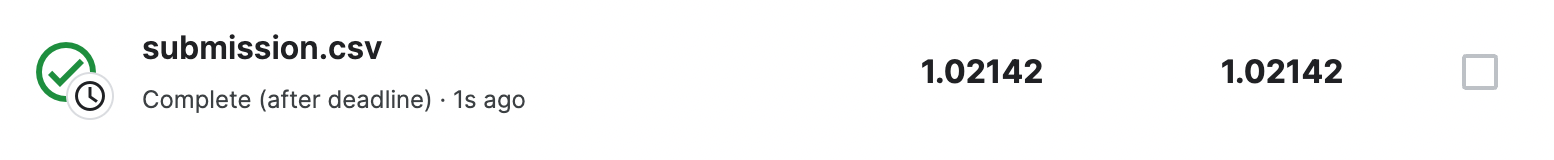

제출 결과 평가점수는 1.02142입니다. 이 점수면 2,773등이므로 3,242명 중 상위 85.5%입니다. 만족스럽지 못한 결과군요. 다음 절에서는 다른 모델들과 최적화 기법을 이용하여 더 높은 등수에 도전해보겠습니다.